In [181]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import Matrix, symbols
from ase.visualize import view
from ase.build import graphene, graphene_nanoribbon
from ase.io import read
import seaborn as sb

sb.set_theme("notebook", "darkgrid")

In [182]:
HL, V, Vd, HR = symbols("H_L, V, V^\dagger, H_R")

H = Matrix([[HL, Vd],
            [V, HR]])
NR = Matrix([[0,0],
             [0, 1]])

In [183]:
H@NR

Matrix([
[0, V^\dagger],
[0,       H_R]])

In [184]:
NR@H

Matrix([
[0,   0],
[V, H_R]])

In [185]:
H@NR - NR@H

Matrix([
[ 0, V^\dagger],
[-V,         0]])

In [186]:
gL, gR = symbols("g_L g_R")

In [187]:
Matrix([[gL, 0],
        [0, gR]]) @ Matrix([[0, Vd],
                            [V, 0]])


Matrix([
[    0, V^\dagger*g_L],
[V*g_R,             0]])

![alt text](ex28-a.png)

## Greens function

In [188]:
## Use broadcasting
def Greens_broadcast(energy, h, h_s, V, eta=1e-4, tol=1e-6, max_iter=30, **kwargs):
    """
    Compute the Green's function for a semi-infinite chain using numpy broadcasting.

    This function calculates the bulk and surface Green's functions for a system with 
    a semi-infinite chain, using iterative convergence. Broadcasting is utilized for 
    efficient matrix operations.

    Parameters
    ----------
    energy : ndarray of shape `(K,)`
        Array of energy values at which the Green's function is evaluated.
    h : ndarray of shape `(N, N)`
        On-site matrix for the bulk region of the semi-infinite chain.
    h_s : ndarray of shape `(N, N)`
        On-site matrix for the surface region (initial site of the chain).
    V : ndarray of shape `(N, N)`
        Hopping matrix that defines the coupling between adjacent sites.
    eta : float, optional
        Small imaginary component added to the energy for numerical stability, by default 1e-4.
    tol : float, optional
        Tolerance for convergence in the iterative calculation, by default 1e-6.
    max_iter : int, optional
        Maximum number of iterations allowed for convergence, by default 30.

    Returns
    -------
    G_bulk : ndarray of shape `(K, N, N)`
        Array representing the bulk Green's function at each energy point.
    G_surf : ndarray of shape `(K, N, N)`
        Array representing the surface Green's function at each energy point.

    Notes
    -----
    - Convergence is achieved when the change in the self-energy terms between iterations 
      is below the specified tolerance (`tol`).
    - The imaginary component (`eta`) ensures numerical stability but should be chosen small 
      enough to avoid affecting the results significantly.
    """
    
    # Get dimensions of input
    K = len(energy)
    N, _ = V.shape
    n_dim = len(V.shape)
    
    # Define alpha_0, beta_0
    alpha = V.transpose().copy()[None, ...]
    beta = V.copy()[None, ...]
    
    # Define epsilon_bulk_0, epsilon_surface_0
    E_bulk = h.copy()[None, ...]
    E_surf = h_s.copy()[None, ...]
    
    # Define perturbated energy of size (K, N, N)
    z = (energy + 1.j*eta)[:, *(None,)*n_dim] * np.identity(N)
    
    # Iterate parameters until convergence or max_iter reached
    for _iteration in range(max_iter):
        
        # Iterate bulk and surface greens energy
        G_bulk = np.linalg.inv(z - E_bulk)    
            
        # Iterate alpha and beta
        alpha_new = alpha @ G_bulk @ alpha
        beta_new =   beta @ G_bulk @ beta
        
        # Compute Left and Right self energies
        L_energy =  beta @ G_bulk @ alpha
        R_energy = alpha @ G_bulk @ beta
        
        # Bulk_self_energy = R_energy + L_energy
        
        # Iterate bulk and surface energy
        E_bulk_new = E_bulk + R_energy + L_energy
        E_surf_new = E_surf + R_energy
        
        # Check for convergence
        if np.max(np.abs(alpha)) < tol:
            # break if one of the values is below the tolerance level
            break
        
        # Iterate by redefining parameters
        alpha = alpha_new.copy()
        beta =  beta_new.copy()
        E_bulk = E_bulk_new.copy()
        E_surf = E_surf_new.copy()
        
    G_surf = np.linalg.inv(z - E_surf)
    return G_bulk, G_surf, E_bulk, E_surf

## For plotting LDOS

In [189]:
# Vpp = 1

# on_site = Vpp * (np.diag(np.ones(3), -1) + np.diag(np.ones(3), 1))

# hopping = Vpp * np.array([[0, 0, 0, 0],
#                           [1, 0, 0, 0],
#                           [0, 0, 0, 1],
#                           [0, 0, 0, 0]])


# Energy = np.linspace(-2, 2, num=1001)
# G_bulk, G_surf, sigma_s, sigma_s = Greens_broadcast(Energy, h=on_site, h_s=on_site, V=hopping, get_Eb=True, eta=1e-2)


# def plot_LDOS(fig, ax, Energy, Greens):
#     colors= ["r", "b", "k", "g"]
#     for i in range(Greens.shape[-1]):
#         ax[i].plot(Energy, -1/np.pi * np.imag(Greens[:, i, i]), label=f"Atom {i+1}", color=colors[i])
        
# # Plotting
# fig, axes = plt.subplots(4, 2, figsize=(6,6), sharex=True, sharey=True )

# plot_LDOS(fig, axes[:, 0], Energy, Greens=G_bulk)
# plot_LDOS(fig, axes[:, 1], Energy, Greens=G_surf)


# for ax in axes[:,0].flatten():
#     ax.set_ylabel(r"$ -\dfrac{1}{\pi}\ \mathrm{Im}(G)$")
#     ax.legend(loc=(1.2,0.5))
# axes[0,0].set_title("Bulk atoms")
# axes[0,1].set_title("Surface atoms")
# fig.tight_layout()

In [190]:
# fig,ax = plt.subplots()
# LDOS = -1/np.pi * np.imag(G_bulk)
# print(LDOS.shape)
# ax.plot(Energy, np.trace(LDOS, axis1=1, axis2=2))

## Creates unique atoms in cell

In [191]:
gr0 = graphene(formula='C2', vacuum=10.)  ## Note you can replace C2 by BN to create hexagonal BN sheets.
a1,a2,a3 = gr0.cell
view(gr0)

<Popen: returncode: None args: ['c:\\Users\\basti\\anaconda3\\envs\\10325\\p...>

In [192]:
A2 = a1 + 2*a2

In [193]:
grsq = gr0.copy()
grtmp = gr0.copy()
atom2 = grtmp[0]
atom2.position +=  (a1+a2)
grsq = grsq + atom2
grtmp = gr0.copy()
atom3 = grtmp[1]
atom3.position +=  a2
grsq = grsq + atom3
#gr1 = gr1 + atom3
grsq.set_cell([a1,A2,a3])
#grsq.get_positions()
#gr1.cell
view(grsq)

<Popen: returncode: None args: ['c:\\Users\\basti\\anaconda3\\envs\\10325\\p...>

## Sort atoms

In [213]:
def sort_atoms(atoms):
    # Use numpy.lexsort to sort by z, then y, then x
    pos = atoms.get_positions()
    sorted_indices = np.lexsort((pos[:, 2], pos[:, 1], pos[:, 0]))
    return atoms[sorted_indices]

grsq = sort_atoms(grsq)
view(grsq)

<Popen: returncode: None args: ['c:\\Users\\basti\\anaconda3\\envs\\10325\\p...>

In [222]:
test = read("struct_a.xyz")
view(test)

<Popen: returncode: None args: ['c:\\Users\\basti\\anaconda3\\envs\\10325\\p...>

## Get positions and hamiltonian

In [218]:
def hamiltonian(xyz):
    a = 1.45 # Å
    
    # get pair-wise distance
    dist = np.linalg.norm(xyz[None, :, :] - xyz[:, None, :], axis=2)
    return np.where((dist < (a + 0.1)) & (dist > 0.1), 1, 0)
# Output a test

xyz = test.get_positions()
H = hamiltonian(xyz)
with np.printoptions(linewidth=110):
    print(H*10)

[[ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [10  0  0 10 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10 10  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 10  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10 10  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10 10  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 10 10  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 10  0  0 10 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10 10  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0

## Transmission

In [219]:
# def k_vec(E, beta, eps):
#     arg = (eps - E)/(2*beta)
#     # print(f"min(arg) = {arg.min()}")
#     # print(f"max(arg) = {arg.max()}")
#     return np.arccos(arg)

# def Infinite_chain(energy, on_site, hopping, beta=1, eps=0, eps_prime=10,  eta=1e-3,):
#     n_dim = len(hopping.shape)
#     K = len(energy)
#     N = hopping.shape[-1]
#     z = (energy + 1.j*eta)[:,  *(None,)*n_dim] * np.identity(N)
    
#     *(G_bulk, G_surf), E_surf = Greens_broadcast(energy, h=on_site, h_s=on_site, V=hopping, eta=eta, eps=eps)
    
#     # E_surf is the `epsilon_s = h + Sigma_R` from exercise 21.
#     BETA =  beta*hopping # make a (N,N) identity matrix with 
#     ENERGY_CHAIN = E_surf - eps
#     ENERGY_CENTER = z - eps_prime
#     ZEROS = np.zeros((N,N))
    
#     # Initilize an empty array
#     MATRIX = np.empty((K, 3*N, 3*N), dtype=np.complex128)
    
    
#     # Construct matrix
#     ##
#     ##            | ENERGY_CHAIN,      BETA     ,    ZEROS      |
#     ## MATRIX  =  |     BETA    ,  ENERGY_CENTER,     BETA      |
#     ##            |    ZEROS    ,      BETA     ,  ENERGY_CHAIN |
#     ##
    
#     # Define element MATRIX[-1, -1] 
#     MATRIX[:, :N, :N] = ENERGY_CHAIN
#     # Define MATRIX[0, 0]
#     MATRIX[:, N:2*N, N:2*N] = ENERGY_CENTER
#     # Define MATRIX[1, 1]
#     MATRIX[:, 2*N:3*N, 2*N:3*N] = ENERGY_CHAIN
    
#     # Define MATRIX[-1, 0]
#     MATRIX[:, :N, N:2*N] = BETA
#     # Define MATRIX[0, -1]
#     MATRIX[:, N:2*N, :N] = BETA
#     # Define MATRIX[0, 1]
#     MATRIX[:, N:2*N, 2*N:3*N] = BETA
#     # Define MATRIX[1, 0]
#     MATRIX[:, 2*N:3*N, N:2*N] = BETA
    
#     # Define MATRIX[-1, 1]
#     MATRIX[:, :N, 2*N:3*N] = ZEROS
#     # Define MATRIX[1, -1]
#     MATRIX[:, 2*N:3*N, :N] = ZEROS
    
#     G = np.linalg.inv(MATRIX)
#     return G

# # G_L = Infinite_chain(energy, on_site=HL, hopping=VL)
# # R_L = Infinite_chain(energy, on_site=HR, hopping=VR)



In [220]:
def compute_transmission(xyz_sorted, energy, N_L, N_R, eta=1e-3):
    
    Ham = hamiltonian(xyz_sorted)
    
    # print(Ham)
    
    
    H_D = Ham[N_L:-N_R, N_L:-N_R]
    
    print(Ham)
    # print(Ham)
    N_ham = Ham.shape[0] # hamiltonian is of shape (N_ham, N_ham)
    n_dim = len(Ham.shape)
    z = (energy + 1.j*eta) # perturbed energy times identity matrix
    zI = z[:, None, None] * np.identity(H_D.shape[0])
    
    # Construct matrix
    ##
    ##            |    H_L   ,  V_L^T   |
    ##   Left  =  |    V_L   ,  H_L     |
    ##
    
    H_L = Ham[:N_L, :N_L]
    V_L = Ham[N_L:2*N_L, :N_L]

    
    
    Gb_L, Gs_L, _Eb_L, _Es_L = Greens_broadcast(energy, h=H_L, h_s=H_L, V=V_L, eta=eta)
    
    
    # Construct matrix
    ##
    ##            |    H_R   ,  V_R^T   |
    ##   Right =  |    V_R   ,  H_R     |
    ##
    
    H_R = Ham[-N_R:, -N_R:]
    V_R = Ham[-N_R:, -2*N_R:-N_R]
    
    Gb_R, Gs_R, _Eb_R, _Es_R = Greens_broadcast(energy, h=H_R, h_s=H_R, V=V_R, eta=eta)
    
    
    V_C_L = Ham[N_L:-N_R, :N_L]
    V_C_R = Ham[N_L:-N_R, -N_R:]
    
    Sigma_L = V_C_L @ Gs_L @ V_C_L.transpose().conj()   
    Sigma_R = V_C_R @ Gs_R @ V_C_R.transpose().conj()
    
    G_D = np.linalg.inv(zI - H_D - Sigma_L - Sigma_R)
    
    Gamma_L = -2*np.imag(Sigma_L)
    Gamma_R = -2*np.imag(Sigma_R)
    
    Ts = Gamma_R @ G_D @ Gamma_L @ G_D.transpose(0, 2, 1).conj()
    
    
    return np.trace(Ts, axis1=1, axis2=2), G_D, Gb_R, Gb_L

[[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]]


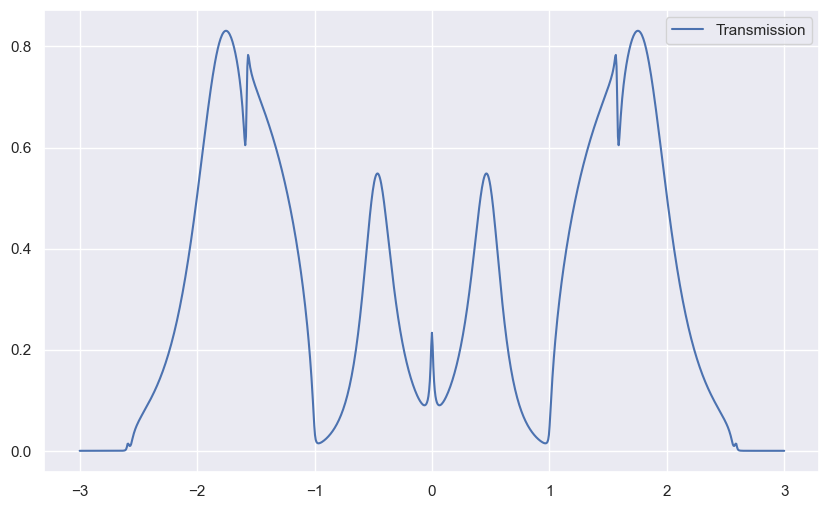

In [221]:
E = np.linspace(-3, 3, num=1001)

T, G_D, Gb_R, Gb_L = compute_transmission(xyz, E, 4, 4, eta=1e-2)
fig, ax = plt.subplots(1,1, figsize=(10,6))

# ax.plot(E, -np.trace(Gb_L.imag, axis1=1, axis2=2), label="Left",  color="k", lw=3)
# ax.plot(E, -np.trace(Gb_R.imag, axis1=1, axis2=2), label="Right", color="r", lw=2.5, linestyle=":")
# ax.plot(E, -np.trace(G_D.imag,  axis1=1, axis2=2), label="G_D")
ax.plot(E, T.real, label="Transmission")

ax.legend(); 

In [200]:
view(test)

<Popen: returncode: None args: ['c:\\Users\\basti\\anaconda3\\envs\\10325\\p...>